In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ucs = pd.read_csv('../../data/clean/ucs_cleaned.csv', parse_dates=['Date of Launch'])

LAUNCH MASS

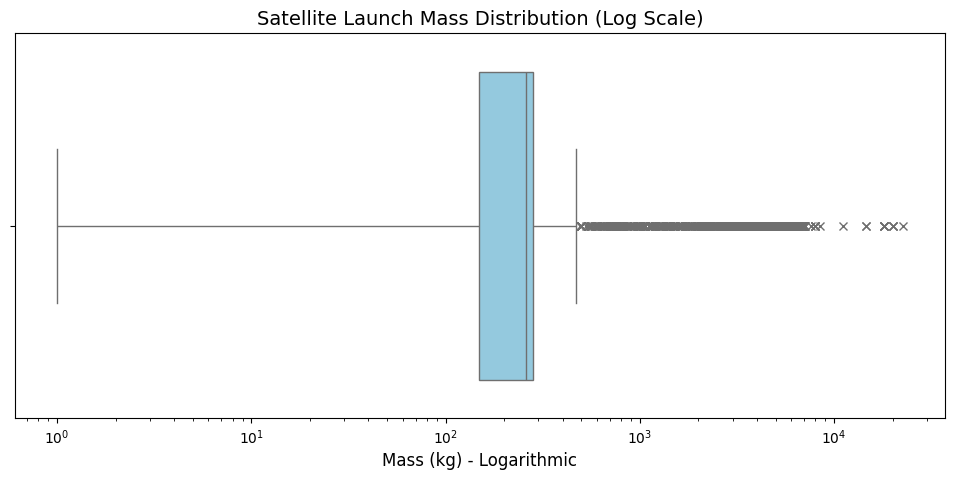

In [10]:
plt.figure(figsize=(12, 5))
sns.boxplot(x=ucs['Launch Mass (kg.)'], color='skyblue', 
            flierprops={"marker": "x", "markerfacecolor": "red"})

plt.xscale('log')

plt.title('Satellite Launch Mass Distribution (Log Scale)', fontsize=14)
plt.xlabel('Mass (kg) - Logarithmic', fontsize=12)
plt.show()

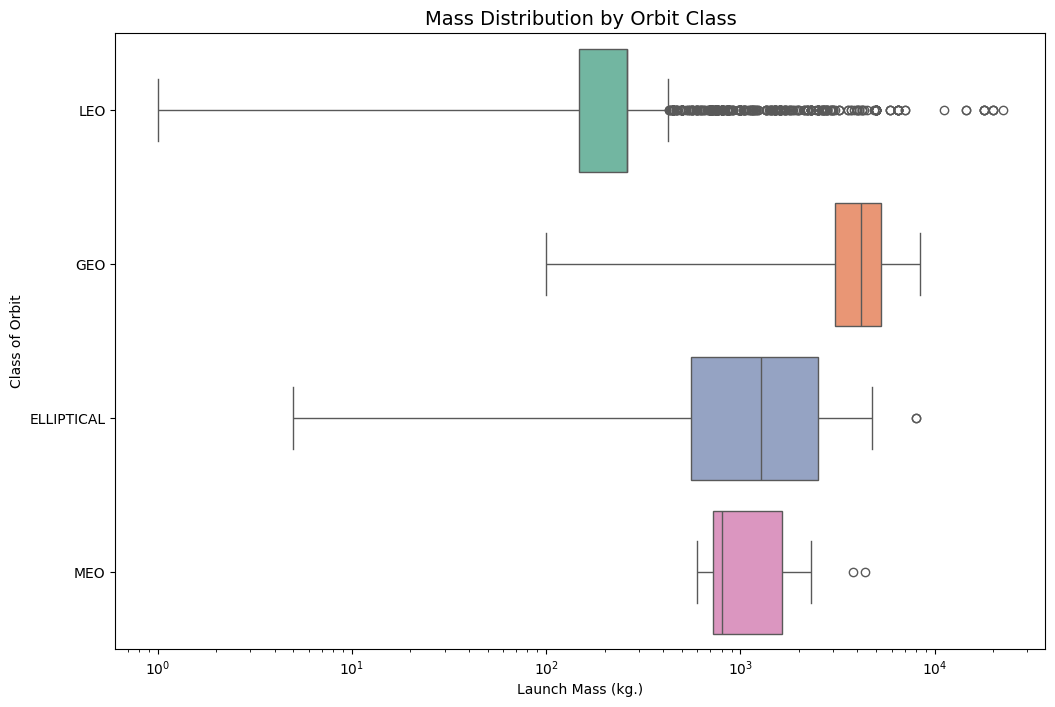

In [11]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=ucs, 
            x='Launch Mass (kg.)', 
            y='Class of Orbit', 
            hue='Class of Orbit', 
            palette='Set2', 
            legend=False)

plt.xscale('log')
plt.title('Mass Distribution by Orbit Class', fontsize=14)
plt.show()

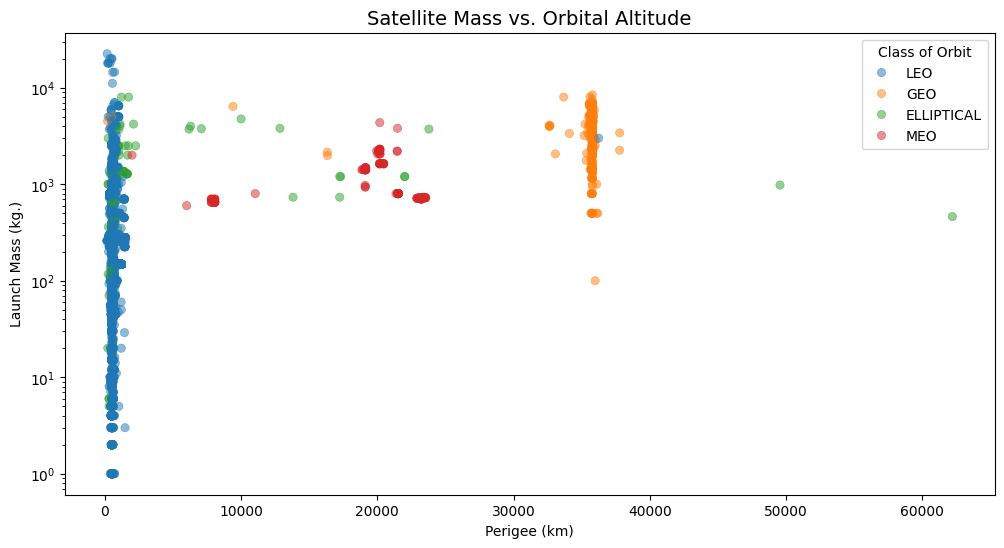

In [12]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
                data = ucs,
                x = 'Perigee (km)',
                y = 'Launch Mass (kg.)', 
                hue = 'Class of Orbit',
                alpha = 0.5,
                edgecolor = None)

plt.yscale('log')
plt.title('Satellite Mass vs. Orbital Altitude', fontsize=14)
plt.show()

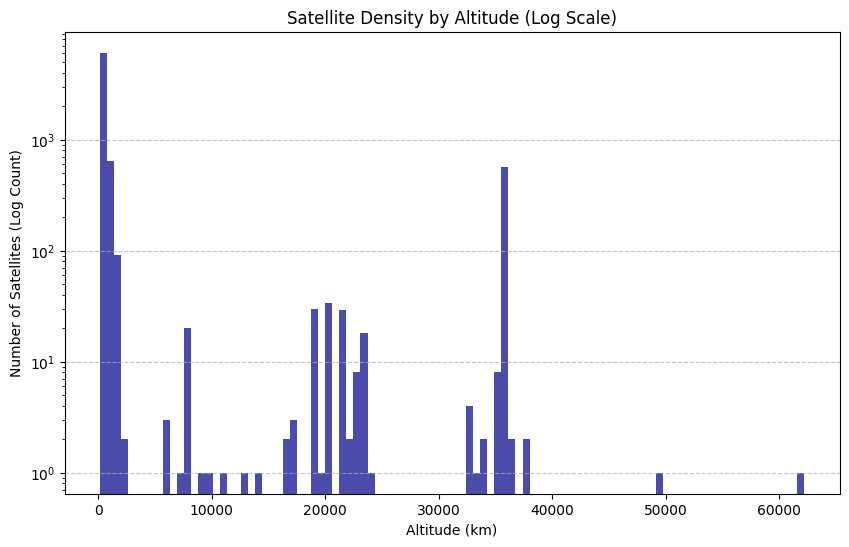

In [13]:
plt.figure(figsize=(10,6))
plt.hist(ucs['Perigee (km)'], bins=100, color='darkblue', alpha=0.7)
plt.yscale('log') 
plt.title('Satellite Density by Altitude (Log Scale)')
plt.xlabel('Altitude (km)')
plt.ylabel('Number of Satellites (Log Count)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Axes: xlabel='Date of Launch'>

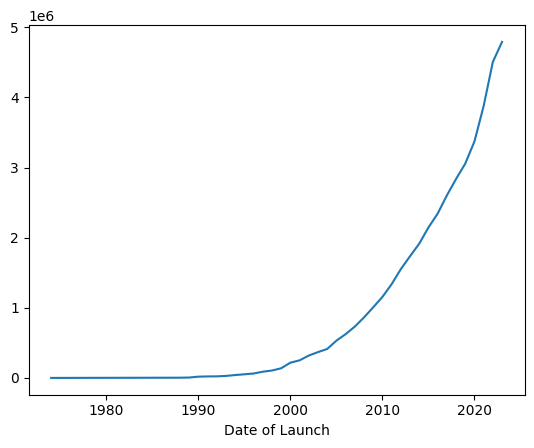

In [14]:
mass_trend = ucs.groupby(ucs['Date of Launch'].dt.year)['Launch Mass (kg.)'].sum().cumsum()
mass_trend.plot()

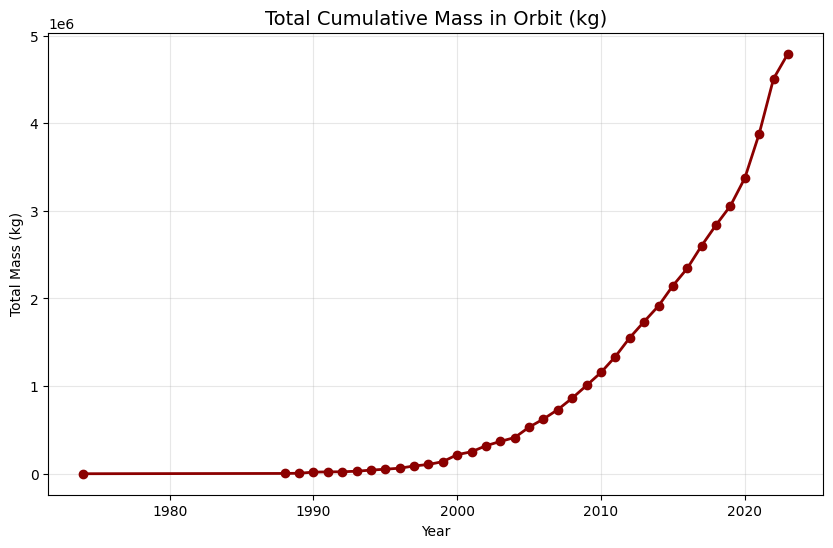

In [15]:
mass_by_year = ucs.groupby(ucs['Date of Launch'].dt.year)['Launch Mass (kg.)'].sum().cumsum()

plt.figure(figsize=(10, 6))

mass_by_year.plot(kind='line', marker='o', color='darkred', linewidth=2)

plt.title('Total Cumulative Mass in Orbit (kg)', fontsize=14)
plt.ylabel('Total Mass (kg)')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)
plt.show()